# Cyclistic Bike Share Regression
## March 2023

## Let's Load our Packages

In [4]:
library(easypackages)
library(MASS)
libraries(c("ISLR", "tidyverse","caTools","ggthemes"))
library("lubridate")

All packages loaded successfully



## Lets Load the Dataset

In [36]:
bikes = read.csv("bikeshare copy.csv")
head(bikes) ##We are trying to predict the total count of bikes rented during each hour covered by the set


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


## Exploratory Data Analysis

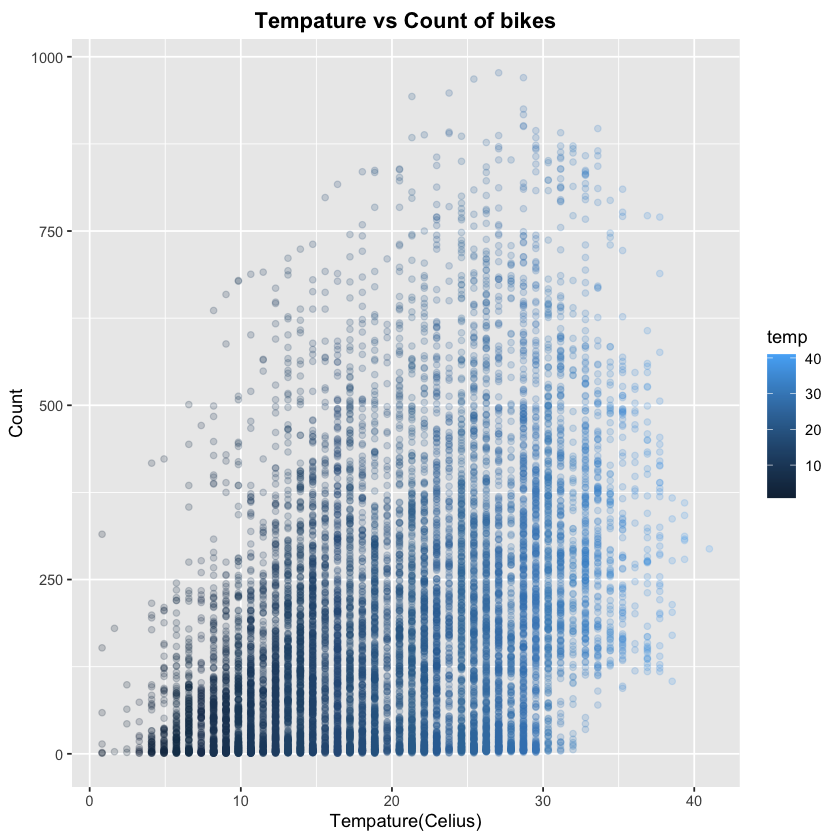

In [21]:
ggplot(bikes, aes(x = temp, y = count)) + geom_point(aes(color = temp), alpha = 0.2)+
labs(x = "Tempature(Celius)", y = "Count", title = "Tempature vs Count of bikes")+
theme(plot.title = element_text(hjust = 0.5, vjust = 0.5, face = 'bold'))


If you analyze the visualization above, as the tempature increases then the amount of total count of bikes increases as well. This could provide somen interesting insights but we will need to further explore.

In [39]:
##Converting the date time format to date 
bikes$datetime = as.POSIXct(bikes$datetime, format = "%Y-%m-%d %H:%M:%S")
head(bikes)
tail(bikes$datetime)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


[1] "2012-12-19 18:00:00 EST" "2012-12-19 19:00:00 EST"
[3] "2012-12-19 20:00:00 EST" "2012-12-19 21:00:00 EST"
[5] "2012-12-19 22:00:00 EST" "2012-12-19 23:00:00 EST"

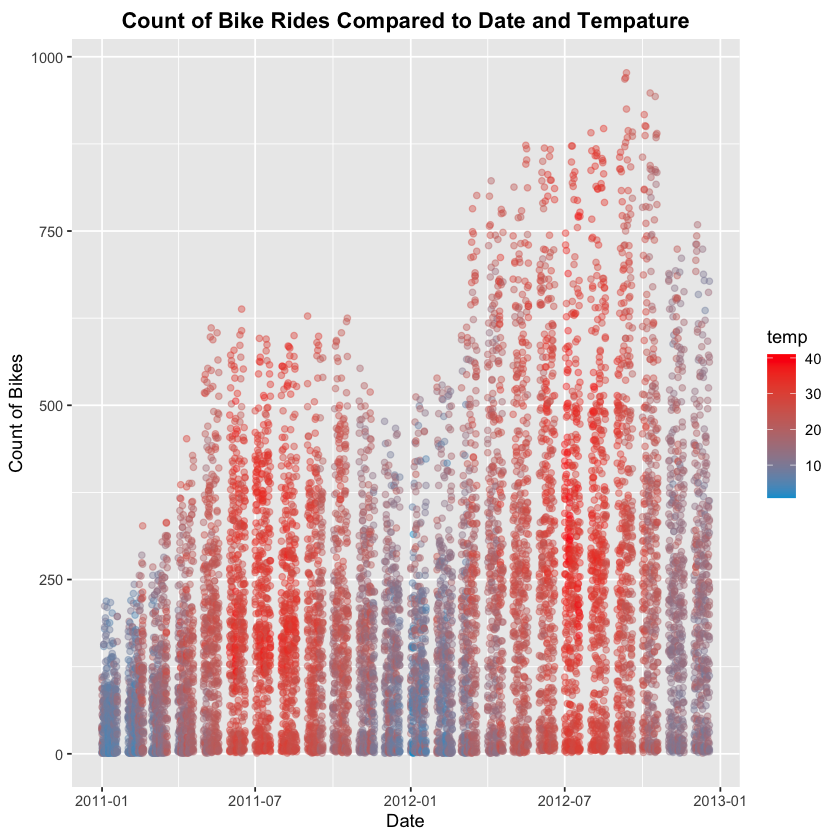

In [20]:
#Lets plot datetime versus count
ggplot(bikes, aes(x = datetime, y = count)) + geom_point(aes(color = temp), alpha = 0.4)+
  scale_color_gradient(low = "#009ed3",high = "red") + labs(title = "Count of Bike Rides Compared to Date and Tempature",x = 'Date', y = 'Count of Bikes')+
  theme(plot.title = element_text(hjust = 0.5, vjust = 0.5, face = 'bold'))


**There is a seasonality to the data, for winter and summer. The bike rental counts are increasing general. Might present a problem with using a linear regression model because if the model is non-linear then it would be too rigid for the fit.**

In [9]:
##Correlations between variables
new.df = dplyr::select(bikes,temp,count)
cor.data = cor(new.df)
cor.data


,temp,count
temp,1.0000000,0.3944536
count,0.3944536,1.0000000


[1] "datetime"   "season"     "holiday"    "workingday" "weather"   
 [6] "temp"       "atemp"      "humidity"   "windspeed"  "casual"    
[11] "registered" "count"      "hour"

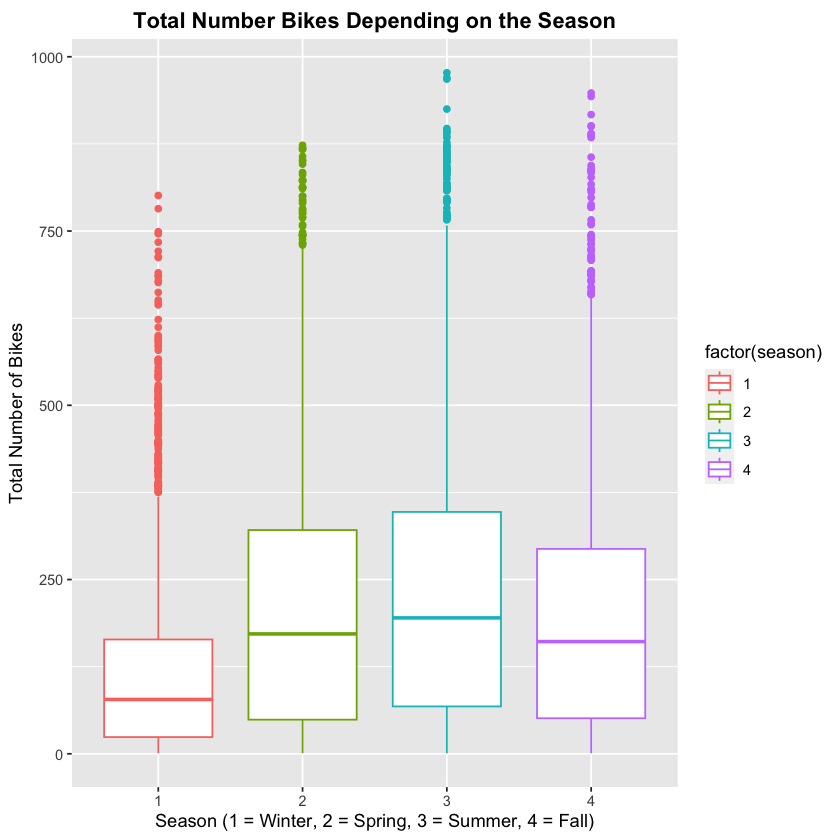

In [29]:
#There is a slight correlation between temp and count of bikes. Lets investigate further
names(bikes)
ggplot(bikes, aes(x = factor(season), y = count)) + geom_boxplot(aes(color = factor(season)))+
labs(title = 'Total Number Bikes Depending on the Season',x = 'Season (1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall)', y = 'Total Number of Bikes')+
theme(plot.title = element_text(hjust = 0.5, vjust = 0.5, face = 'bold'))


In [40]:
##Since we want to predict the count at each hour, lets create an hour column
bikes$hour = hour(bikes$datetime)
head(bikes)
tail(bikes)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>
10881,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,23,546,569,18
10882,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
10883,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
10884,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
10885,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
10886,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


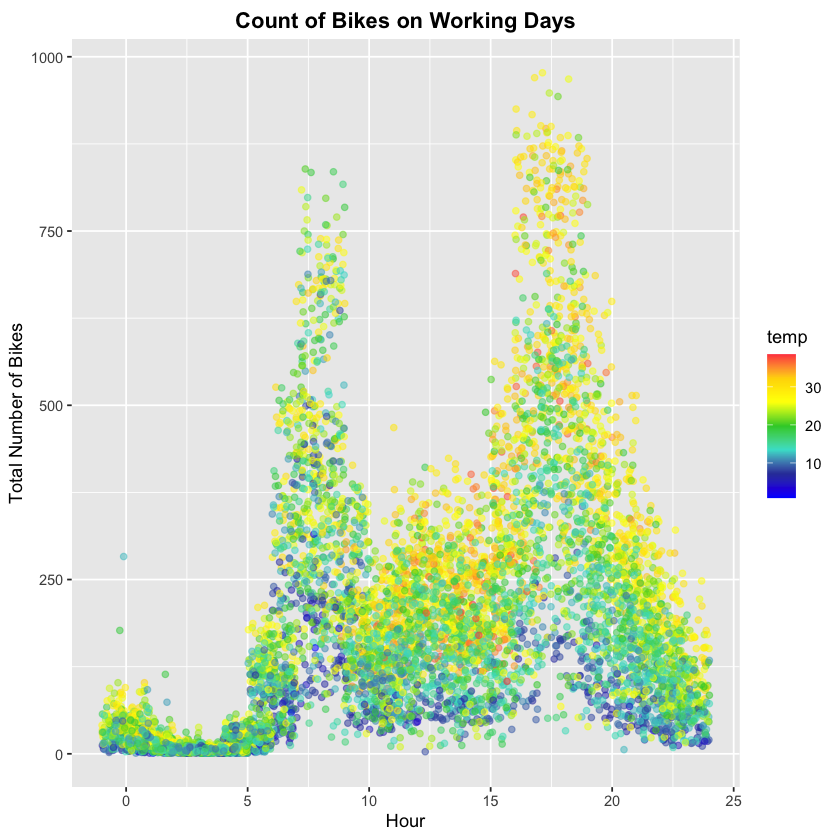

In [44]:
## Now plot count versus hours on working days and non working days

pl1 = bikes %>% 
  subset(workingday == 1) %>% 
  ggplot(aes(x = hour, y = count)) + geom_point(aes(color = temp),alpha=0.5,position = position_jitter(width = 1, height = 0))+
  scale_color_gradientn(colors =c("blue","#3240a8","#40e0d0","#32cd32","#feff00","#ffd700","#ff494d"))+
  labs(x = "Hour", y = "Total Number of Bikes", title = 'Count of Bikes on Working Days')+
  theme(plot.title = element_text(hjust = 0.5, vjust =0.5, face = 'bold')); pl1

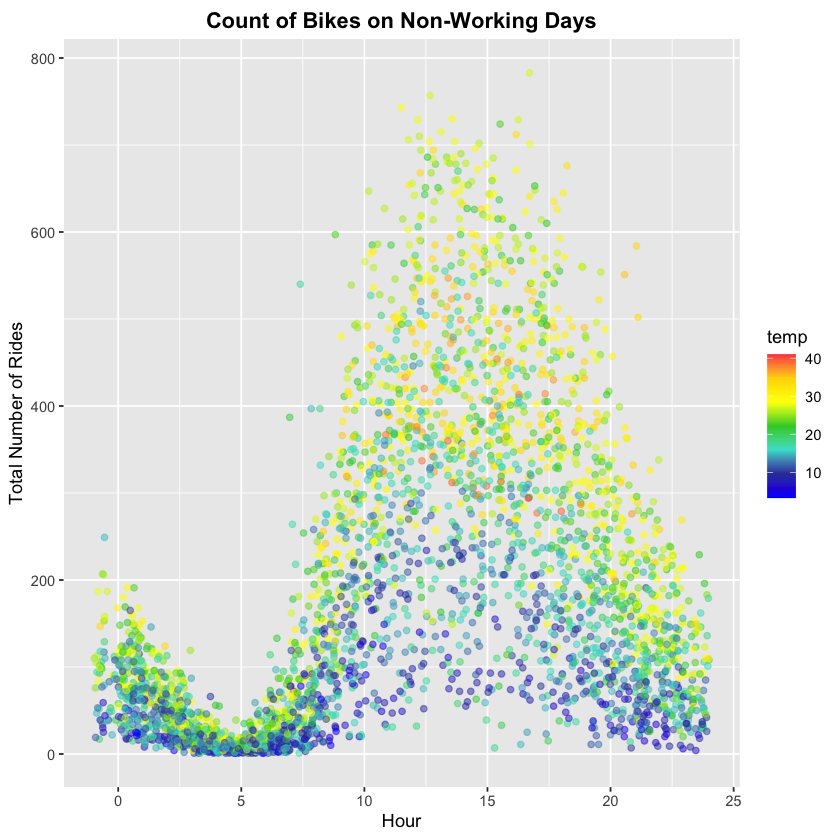

In [47]:
#Non working days
pl2 = bikes %>% 
  subset(workingday == 0) %>% 
  ggplot(aes(x = hour, y = count)) + geom_point(aes(color = temp),alpha=0.5,position = position_jitter(width = 1, height = 0))+
  scale_color_gradientn(colors =c("blue","#3240a8","#40e0d0","#32cd32","#feff00","#ffd700","#ff494d"))+
  labs(title = "Count of Bikes on Non-Working Days", x = "Hour", y = "Total Number of Rides")+
  theme(plot.title = element_text(hjust = 0.5, vjust = 0.5, face = 'bold')); pl2

In [14]:
#Building Models
temp.model = lm(count~temp, data = bikes)
summary(temp.model)



Call:
lm(formula = count ~ temp, data = bikes)

Residuals:
    Min      1Q  Median      3Q     Max 
-293.32 -112.36  -33.36   78.98  741.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0462     4.4394   1.362    0.173    
temp          9.1705     0.2048  44.783   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 166.5 on 10884 degrees of freedom
Multiple R-squared:  0.1556,	Adjusted R-squared:  0.1555 
F-statistic:  2006 on 1 and 10884 DF,  p-value: < 2.2e-16


In [15]:
##How many bike rentals would we predict if the temp was 25 degrees Celsius
predict(temp.model,data.frame(temp = 25), interval = "confidence")


,fit,lwr,upr
1,235.3097,231.6429,238.9765


In [48]:
##Lets change the hour column to a column of numeric values
head(bikes)
bikes$hour = sapply(bikes$hour, as.numeric)
head(bikes)

str(bikes$hour)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5


 num [1:10886] 0 1 2 3 4 5 6 7 8 9 ...


## Build a new model 

[1] "datetime"   "season"     "holiday"    "workingday" "weather"   
 [6] "temp"       "atemp"      "humidity"   "windspeed"  "casual"    
[11] "registered" "count"      "hour"


Call:
lm(formula = count ~ season + holiday + workingday + weather + 
    temp + humidity + windspeed + hour, data = bikes)

Residuals:
    Min      1Q  Median      3Q     Max 
-330.53 -102.40  -31.32   66.82  683.87 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 344.65119   86.51202   3.984 6.82e-05 ***
season       22.78859    1.42867  15.951  < 2e-16 ***
holiday     -11.38518    9.27384  -1.228  0.21960    
workingday   -1.81558    3.31722  -0.547  0.58417    
weather       5.19728    2.62598   1.979  0.04782 *  
temp          8.35521    0.29111  28.702  < 2e-16 ***
humidity     -2.98796    0.09454 -31.606  < 2e-16 ***
windspeed     0.55235    0.19642   2.812  0.00493 ** 
hour        -10.55070    4.63932  -2.274  0.02297 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 156 on 10877 degrees of freedom
Multiple R-squared:  0.2593,	Adjusted R-squared:  0.2588 
F-statistic:   476 on 8 and 10877 DF,  p-va

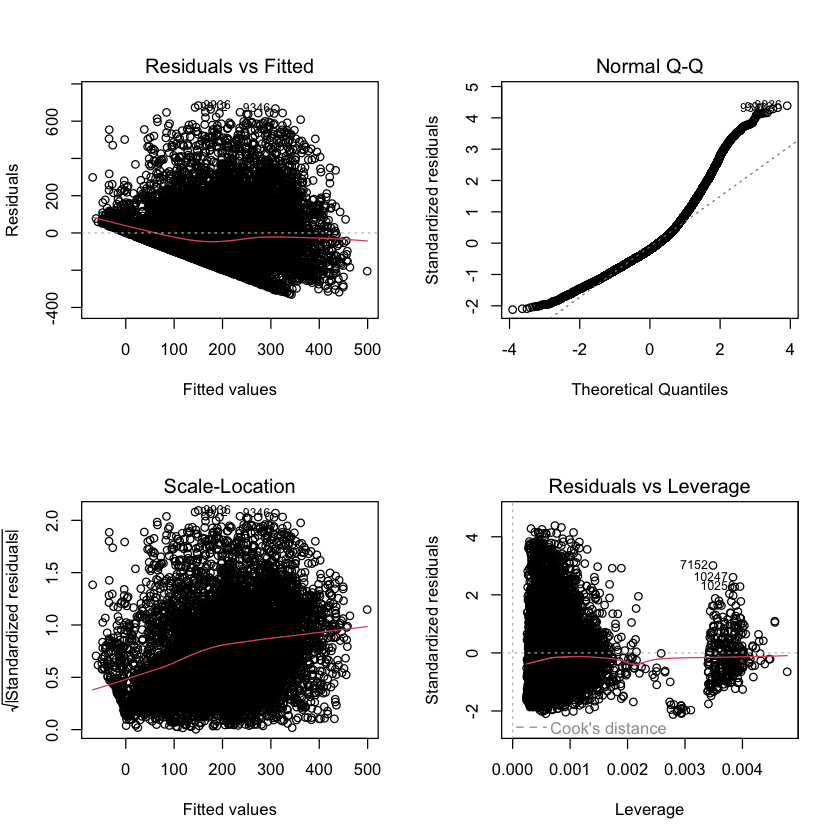

In [17]:
colnames(bikes)
new.model = lm(count~season+holiday+workingday+weather+temp+humidity+windspeed+hour,bikes)
summary(new.model)
par(mfrow = c(2,2))
plot(new.model)
